# Mineral segmentation


## Motivation
This notebook outlines how to take a series of CT images that represent a 3D volume and segment them using the watershed algorithm. In brief the pipeline is as follows:
1. Import data. 
   - .tif, .png, or .jpg images
   - downsample the data if required
2. Rescale and normalize data so that pixel values are between 0 and 1
3. Denoise the data
   - allows for easier phase identification in histograms
4. Create an elevation map of the image using image gradient algorithms
   - accepts all methods found in scikit-image: 'sobel', 'roberts', 'scharr', 'prewitt'
5. Choose marker values as starting points for the watershed segmentation algorithm
6. Run the watershed segmentation algorithm
7. Export data
   - image stack (e.g., .png, .tif, .npy)
   - segmentation metadata (i.e., all user decisions) for reproducibility
   
   
This notebook notebook takes a "from scratch" approach to the above tasks. For a clean version that utilizes the ```ctpy``` module please see the ```mineral_segmentation_clean.ipynb``` notebook
   
## Import dependencies

In [16]:
# bulk file import
import glob as glob

# for...warnings
import warnings

# visualization
import matplotlib.pyplot as plt

# array operations
import numpy as np

# saving metadata
import pandas as pd
from PIL import Image

# image processing
from skimage import exposure, restoration
from skimage.filters import prewitt, roberts, scharr, sobel
from skimage.segmentation import watershed
from skimage.transform import downscale_local_mean, rescale, resize

# progress bar
from tqdm import tqdm

%matplotlib inline

## Import data
Here we will import and also downsample our data so that it is more manageable on a standard personal computer

In [107]:
# path to the folder where your 2D images reside
filepath = r"D:\Jorgenson_CT_work\0103_19CJ13_x100\32bit"
# For figure labeling and saving purposes
name = "0103_19CJ13_x100"


# helper function to import an entire folder of 2D images
def import_stack(filepath, filetype, name, downsample=False):
    """
    import_stack imports a stack of images and converts them into a 3D numpy 
    array so that it can be further processed using either numpy functions or
    scikit-image based functions in the CTPy functions in the module.
    
    import_stack(filepath,filetype,name):
        
    Parameters
    ----------
    filepath : string
        file directory for where the series of images is located. It is recommended
        that the files be in their own folder, as the function will import all 
        files from the directory as specified in the 'filetype' argument. 
    filetype : string
        type of file the images are. Choices are 'tif', 'png', 'jpg', or 'dicom'
    name : string
        name of the dataset you are working with. This will be utilized for 
        figure labeling and filesaving functions later on.
    downsample: int
        factor to downsample by. 

    Returns
    -------
    stack : ndarray
        3D numpy ndarray where the first two dimensions pertain to an individual
        image (e.g., slice) in the dataset and the last dimension pertains to 
        the slice number in the stack. Since numpy arrays are in [rows,columns,depth]
        format, this is analagous to [y,x,z]

    """
    if "png" in filetype:
        # creates a list of filepaths for each 2D images
        infiles = sorted(glob.glob("{}/*.png".format(filepath)))

    elif "tif" in filetype:
        # creates a list of filepaths for each 2D images
        infiles = sorted(glob.glob("{}/*.tif".format(filepath)))

    elif "jpg" in filetype:
        # creates a list of filepaths for each 2D images
        infiles = sorted(glob.glob("{}/*.jpg".format(filepath)))
        
    elif "dicom" in filetype:
        #this grabs every single item in the dirpath 
        all_files = glob.glob("{}/*".format(filepath))

        #this should remove all file extensions e.g. .png .tiff .xlsx
        #anything with a ".", but NOT FOLDERS
        infiles = sorted([d for d in all_files if '.' not in d])
        
    
    if "dicom" in filetype:
        #open the first dicom file and get the data as a numpy array
        im = dicom.dcmread(infiles[0]).pixel_array
        # create an 'empty' array filled with zeros, (Slices X width X length) is the shape of the array.
        # this is equivalent to (z, y, x) in cartesian space
        stack = np.zeros((len(infiles), im.shape[0], im.shape[1]))

    
    else:
   
        # open the first image to acquire image size
        im = Image.open(infiles[0])

        # create an 'empty' array filled with zeros, (Slices X width X length) is the shape of the array.
        # this is equivalent to (z, y, x) in cartesian space
        stack = np.zeros((len(infiles), im.size[1], im.size[0]))

    # loop the files, each iteration adds one slice layer into the array.
    i = 0
    print("Importing images")
    for imfile in tqdm(infiles, total = len(infiles), unit = 'files'):
        if "dicom" in filetype:
            im = dicom.dcmread(imfile).pixel_array
        else:
            
            im = Image.open(imfile)
            
        stack[i, :, :] = np.array(im)
        i += 1

    # force each image to have a shape comprised of two even numbers
    # such that we can at least downsample by a factor of 2

    # original rows and cols dimensions
    input_size_rows = stack.shape[1]
    input_size_cols = stack.shape[2]

    # make row and column dimensions even numbers
    if input_size_rows % 2 == 0:

        input_size_rows = input_size_rows

    else:
        input_size_rows = input_size_rows - 1

    if input_size_cols % 2 == 0:

        input_size_cols = input_size_cols

    else:

        input_size_cols = input_size_cols - 1

    # update the stack dimensions by trimming off a pixel
    # from either the rows or the columns (or both)
    stack = stack[:, :input_size_rows, :input_size_cols]

    # DOWNSAMPLING
    ## uses following example from scipy cookbook
    # https://scipython.com/blog/binning-a-2d-array-in-numpy/

    # note this will only downsample by common factors between
    # the rows and columns dimensions

    # here's a helper function to figure that out:
    def cf(num1, num2):
        common_factors = []
        for i in range(1, min(num1, num2) + 1):
            if num1 % i == num2 % i == 0:
                common_factors.append(i)
        return common_factors

    # downsampled rows and cols dimensions
    output_size_rows = stack.shape[1] // downsample
    output_size_cols = stack.shape[2] // downsample

    # array of potential downsampling factors based on input
    # shape
    common_factors = np.array(cf(input_size_rows, input_size_cols))

    # downsample if the specified factor is a potential common factor
    if downsample in common_factors:
        print("downsampling images")
        # bin size for rows and cols
        bin_size_rows = input_size_rows // output_size_rows
        bin_size_cols = input_size_cols // output_size_cols

        # create empty array to fill with downsampled data
        # this will have downsampled rows and cols but NOT
        # height

        stack_downsample = np.zeros(
            (stack.shape[0], output_size_rows, output_size_cols)
        )

        # loop through and complete downsampling for every slice and
        # add it to the empty array defined above
        for i in tqdm(range(stack.shape[0]), total = stack.shape[0], unit = 'images'):

            im = stack[i, :, :]
            im_downsample = (
                im.reshape(
                    (output_size_rows, bin_size_rows, output_size_cols, bin_size_cols)
                )
                .mean(-1)
                .mean(1)
            )

            stack_downsample[i, :, :] = im_downsample

        stack_downsample = stack_downsample[::downsample, :, :]

        print("your original stack dimensions are {}".format(stack.shape))
        print("your downsampled stack dimensions are {}".format(stack_downsample.shape))

        return stack_downsample, stack.shape

    elif downsample not in common_factors:
        warnings.warn(
            """You have chosen a downsampling factor that is not a common factor \n of your row 
            and column shapes and have therefore returned the original data. Please choose an 
            appropriate downsampling factor"""
        )
        print("your stack dimensions are {}".format(stack.shape))
        print("potential downsampling factors: {}".format(common_factors))
        return stack, stack.shape

    elif downsample is False and stack.ravel().shape > 125000000:
        warnings.warn(
            """please condsider downsampling your stack as it is very large and 
            image processing may become much more difficult pending your computer 
            capabilities. Check your Activity monitor for advice.
            """
        )
        return stack, stack.shape

    else:
        print("your stack dimensions are {}".format(stack.shape))

        return stack, stack.shape




stack, original_stack_shape = import_stack(filepath, "tif", name, downsample=2)
stack_1D = stack.flatten()

Importing images


100%|█████████████████████████████████████████████████████████████████████████████| 598/598 [00:30<00:00, 19.33files/s]


downsampling images


100%|███████████████████████████████████████████████████████████████████████████| 598/598 [00:01<00:00, 429.27images/s]


your original stack dimensions are (598, 606, 520)
your downsampled stack dimensions are (299, 303, 260)


## Rescale the stack
Looking at our histogram we can see that there are a very small amount of pixels with values at the far high end of the attenuation range. Because these pixels encompass negligible proportions of our data we are going to remove them to better fill the normalized range. This is known as contrast stretching and should allow us to see subtleties in our data better. We normalize the data because Python's ```sckit-image``` processing functions tend to work better with values between 0 and 1. 

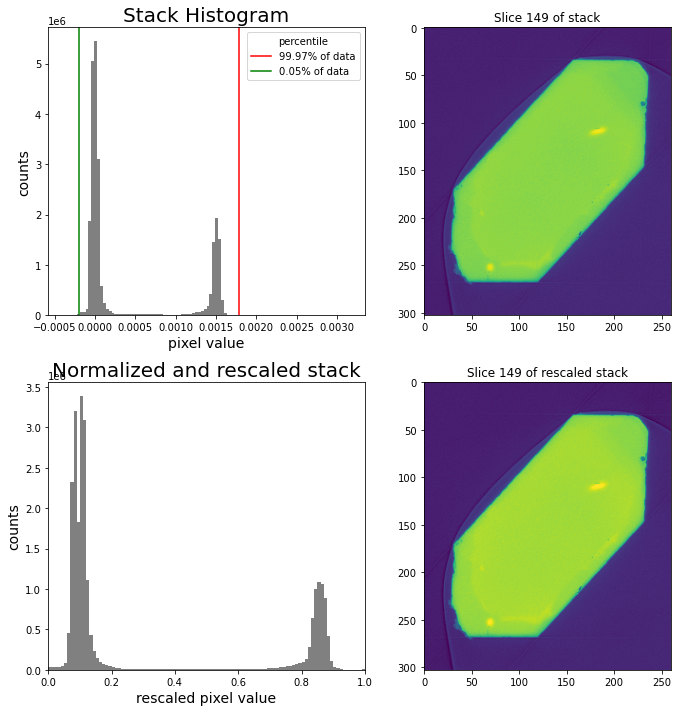

In [108]:
# helper function to rescale the data between 0 and 1 and also trim
# it at upper and lower limits
def rescale_stack(lower_lim, upper_lim, stack):
    """
    rescale_stack uses lower and upper defined boundaries to apply contrast 
    contrast stretching to a desired stack. In brief, it uses percentiles as 
    the boundary conditions so that a small amount of pixel values do not 
    perturb the colormap, making small changes in value harder to see. Plots
    the results of the contrast stretching by comparing the grayscale values
    for a single slice using both a histogram and 2D image. 
    
    rescale_stack(lower_lim,upper_lim,stack,slice_number):
        
    Parameters
    ----------
    lower_lim : scalar
        lower limit of the rescale range in percent (e.g., .01)
    upper_lim : scalar
        upper limit of the rescale range in percent (e.g., 99.99)
    stack : ndarray
        dataset to apply the contrast stretching to. Must be a 3D array
    
    Returns
    -------
    stack_rescale : ndarray
        contrast stretched and rescaled dataset in the same shape as the input
        stack
    stack_rescaleArray1D : 1D array
        contrast stretched data flattened to 1D so it can be visualized in a 
        histogram

    """

    # find the pixel values of the upper and lower percentile limits
    plow, phigh = np.percentile(stack, (lower_lim, upper_lim))

    # use those values to rescale the data
    stack_rescale = exposure.rescale_intensity(stack, in_range=(plow, phigh))

    stack_normal = (stack_rescale - stack_rescale.min()) / (
        stack_rescale.max() - stack_rescale.min()
    )

    stack_normal1D = stack_normal.ravel()

    # Histogram of your whole stack rescaled between 0 and 1
    stackArray1D = stack.ravel()

    return plow, phigh, stack_normal, stack_normal1D


# Call the function
lower_lim, upper_lim = 0.05, 99.97
plow, phigh, stack_normal, stack_normal_1D = rescale_stack(lower_lim, upper_lim, stack)


# plot up the comparison between original stack and rescaled stack
cmap = "viridis"
scale = "linear"
slice_number = stack.shape[0] // 2

fig, ax, = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].hist(stack_1D, bins=100, color="gray")
ax[0, 0].set_title("Stack Histogram", fontsize=20)
ax[0, 0].set_yscale(scale)
ax[0, 0].axvline(phigh, c="r", label="{}% of data".format(upper_lim))
ax[0, 0].axvline(plow, c="g", label="{}% of data".format(lower_lim))
ax[0, 0].legend(loc="best", title="percentile")
ax[0, 0].set_ylabel("counts", fontsize=14)
ax[0, 0].set_xlabel("pixel value", fontsize=14)

# show the first image of the stack
ax[0, 1].imshow(stack[slice_number], cmap=cmap)
ax[0, 1].set_title("Slice {} of stack".format(slice_number))

# rescaled data

ax[1, 0].hist(stack_normal_1D, bins=100, color="gray")
ax[1, 0].set_yscale(scale)
ax[1, 0].set_ylabel("counts", fontsize=14)
ax[1, 0].set_xlabel("rescaled pixel value", fontsize=14)
ax[1, 0].set_title("Normalized and rescaled stack", fontsize=20)
ax[1, 0].set_xlim(0, 1)
# show the first image of the stack
ax[1, 1].imshow(stack_normal[slice_number], cmap=cmap)
ax[1, 1].set_title("Slice {} of rescaled stack".format(slice_number))
fig.tight_layout()

Text(0.5, 0.92, 'Rescaled stack at 15 slice increments')

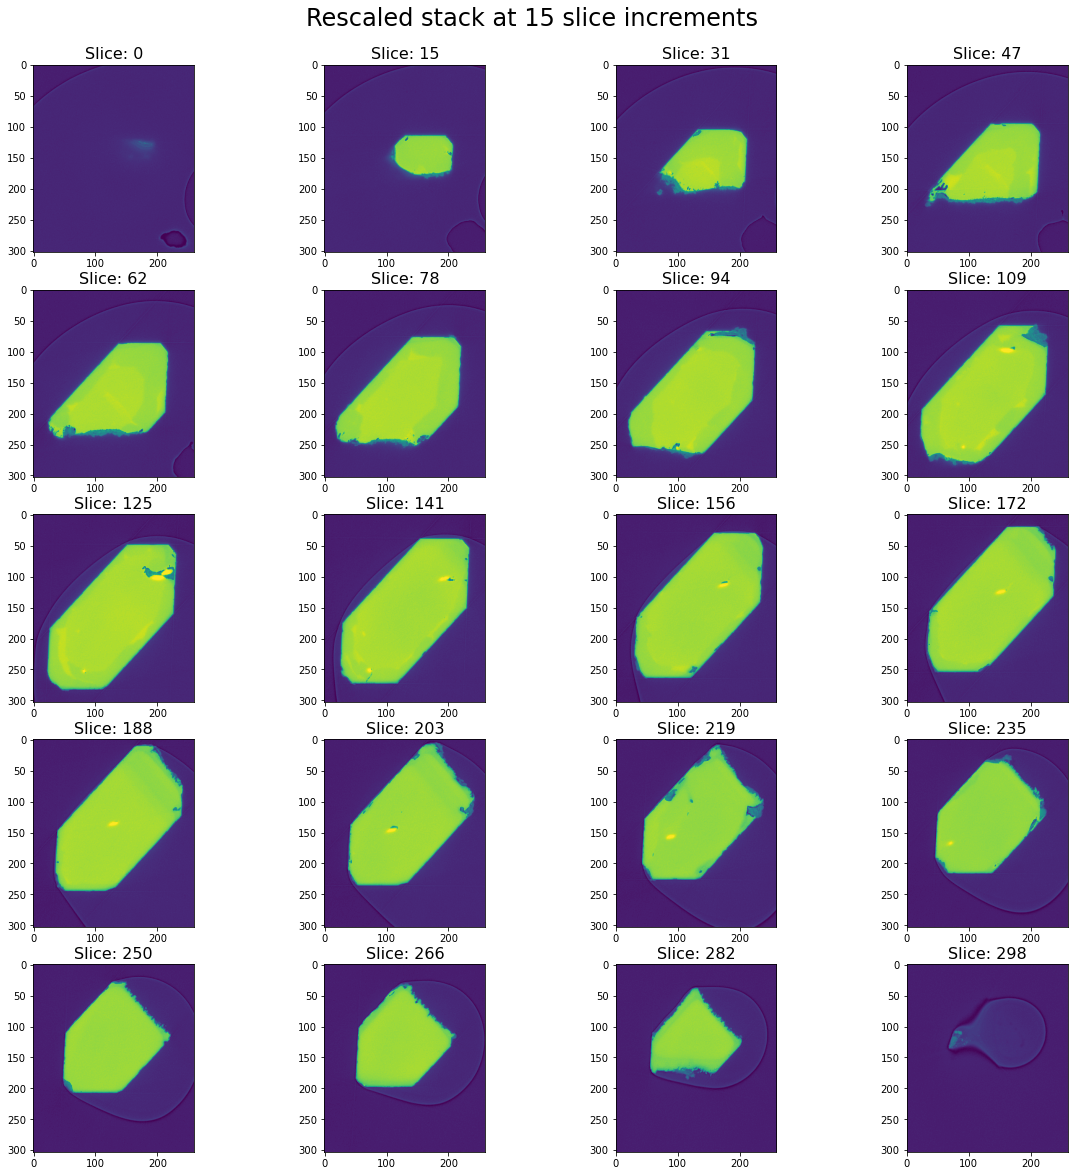

In [109]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
axes = ax.ravel()

for i, a in zip(np.linspace(1, stack.shape[0], 20), axes):
    a.imshow(stack_normal[int(i - 1), :, :], vmin=0, vmax=1)
    a.set_title("Slice: {}".format(int(i - 1)), fontsize=16)
fig.suptitle(
    "Rescaled stack at {} slice increments".format(
        int(
            np.linspace(1, stack.shape[0], 20)[1]
            - np.linspace(1, stack.shape[0], 20)[0]
        )
    ),
    fontsize=24,
    y=0.92,
)

## Refine histogram peaks with non-local means denoising
Denoising the stack with the non-local means algorithm allows for image noise to be removed while still preserving crucial textural information. This noise removal also allows for unique phases (i.e., histogram peaks) to be identified

In [110]:
# helper function for denoising your stack with the non local means function
def denoise_stack(stack_rescale, patch_size, patch_distance):
    """
    denoise_stack applies the non-local-means filter from scikit-image restoration
    module (https://scikit-image.org/docs/dev/api/skimage.restoration.html) to 
    to the entire stack on a slice by slice basis.
    
    denoise_stack(stack_rescale,patch_size,patch_distance):

    Parameters
    ----------
    stack_rescale : ndarray
        data to be denoised. This can be a single image (e.g., 2D array) or 
        whole stack of images (e.g., 3D array)
    patch_size : int
        patch_size argument from scikit-image.restoration.denoise_nl_means:
        "Size of patches used for denoising."
    patch_distance : int
        patch_distance argument from scikit-image.restoration.denoise_nl_means:
        "Maximal distance in pixels where to search patches used for denoising."
    Returns
    -------
    nlm_array : ndarray
        3D array in the same shape as "stack_rescale" that contains the denoised
        pixel values
    nlm_array1D : 1D array
        1D array that contains the denoised pixel values. These values are the 
        same as nlm_array, just flattened so that they can be used for a histogram

    """
    stack_length = len(stack_rescale)
    nlm_smooth = []
    for i in tqdm(range(0, stack_length),total = stack_length,unit = 'images'):
        patch_kw = dict(
            patch_size=patch_size, patch_distance=patch_distance, multichannel=True
        )
        nlm_smooth.append(
            restoration.denoise_nl_means(stack_rescale[i], fast_mode=True, **patch_kw)
        )
    # convert from list to numpy array
    stack_nlm = np.asarray(nlm_smooth)
    stack_nlm_1D = stack_nlm.ravel()

    print("Your stack has been smoothed using the Skimage non-local means algorithm")
    print("patch size: {}".format(patch_size))
    print("patch distance: {}".format(patch_distance))

    return stack_nlm, stack_nlm_1D


# call the non local means denoising helper function
# and specify the patch size and distance
patch_size = 5
patch_distance = 5
stack_nlm, stack_nlm_1D = denoise_stack(stack_normal, patch_size, patch_distance)

100%|████████████████████████████████████████████████████████████████████████████| 299/299 [00:29<00:00, 10.14images/s]

Your stack has been smoothed using the Skimage non-local means algorithm
patch size: 5
patch distance: 5


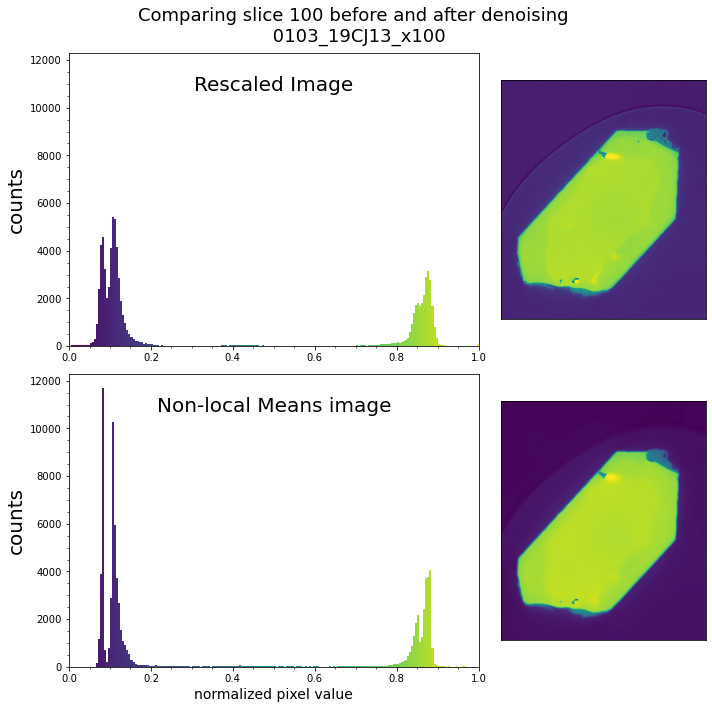

In [112]:
slice_number = 100
colormap = plt.get_cmap(cmap)
slice_nlm_1D = stack_nlm[slice_number].flatten()
slice_1D = stack_normal[slice_number].flatten()

bins = 200

fig, ax = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={"width_ratios": [2, 1],})
fig.suptitle(
    "Comparing slice {} before and after denoising \n {}".format(slice_number, name),
    fontsize=18,
)

# Histogram for rescaled image
counts, bins, patches = ax[0, 0].hist(slice_1D, bins=bins,)
ax[0, 0].minorticks_on()
ax[0, 0].set_xlim(0, 1)
ax[0, 0].set_ylabel("counts", fontsize=20)
ax[0, 0].set_title("Rescaled Image", fontsize=20, y=0.85)

# get the value for center of bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers, patches):
    plt.setp(p, "facecolor", colormap(c))

# rescaled image
ax[0, 1].imshow(stack_normal[slice_number], cmap=cmap)
ax[0, 1].axes.yaxis.set_ticklabels([])
ax[0, 1].axes.yaxis.set_ticks([])
ax[0, 1].axes.xaxis.set_ticklabels([])
ax[0, 1].axes.xaxis.set_ticks([])

# Histogram for non local means image
counts2, bins2, patches2, = ax[1, 0].hist(slice_nlm_1D, bins=bins,)

# get value for center of bins
bin_centers2 = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers2, patches2):
    plt.setp(p, "facecolor", colormap(c))
ax[1, 0].minorticks_on()
ax[1, 0].set_ylim(0, 1.05 * np.max(counts2))

ax[1, 0].set_xlim(0, 1)
ax[1, 0].set_xlabel("normalized pixel value", fontsize=14)
ax[1, 0].set_title("Non-local Means image", fontsize=20, y=0.85)
ax[1, 0].set_ylabel("counts", fontsize=20)


# non local means image
ax[1, 1].imshow(stack_nlm[slice_number], cmap=cmap)
ax[1, 1].axes.yaxis.set_ticklabels([])
ax[1, 1].axes.yaxis.set_ticks([])
ax[1, 1].axes.xaxis.set_ticklabels([])
ax[1, 1].axes.xaxis.set_ticks([])
ax[1, 0].set_ylim(0, 1.05 * np.max(counts2))
ax[0, 0].set_ylim(0, 1.05 * np.max(counts2))
fig.tight_layout()

### Compare pre and post denoised stack

(0.0, 1.0)

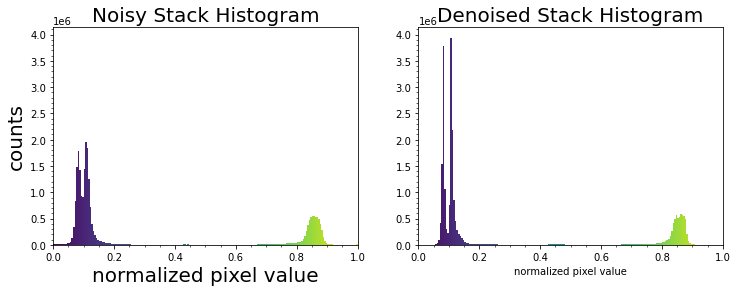

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

counts, bins, patches = ax[0].hist(stack_normal_1D, bins=bins,)
ax[0].set_title("Noisy Stack Histogram", fontsize=20)
ax[0].set_xlabel("normalized pixel value", fontsize=20)
ax[0].set_ylabel("counts", fontsize=20)
ax[0].minorticks_on()


counts2, bins2, patches2 = ax[1].hist(stack_nlm_1D, bins=bins,)

# make histograms colored by normalized pixel value
# first histogram
# get the value for the center of the bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers, patches):
    plt.setp(p, "facecolor", colormap(c))

# second histogram
bin_centers2 = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers2, patches2):
    plt.setp(p, "facecolor", colormap(c))

ax[1].set_title("Denoised Stack Histogram", fontsize=20)
ax[1].set_xlabel("normalized pixel value")
ax[1].minorticks_on()
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
ax[0].set_ylim(0, np.max(1.05 * counts2))
ax[1].set_ylim(0, np.max(1.05 * counts2))
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

## Create elevation map for watershed markers

A brief blurb on the watershed algorithem from [Roerdink and Meijster, 2000](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.10.3852&rep=rep1&type=pdf):

"The watershed transform can be classified as a region-based segmentation approach. The intuitive idea underlying this method comes from geography: it is that of a landscape or topographic relief which is flooded by water, watersheds being the divide lines of the domains of attraction of rain falling over the region [46]. An alternative approach is to imagine the landscape being immersed in a lake, with holes pierced in local minima. Basins (also called ‘catchment basins’) will fill up with water starting at these local minima, and, at points where water coming from different basins would meet, dams are built. When the water level has reached the highest peak in the landscape, the process is stopped. As a result, the landscape is partitioned into regions or basins separated by dams, called watershed lines or simply watersheds."


Here we use the [sobel](https://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html#sphx-glr-auto-examples-edges-plot-edge-filter-py) edge filter to make an "elevation map" as in this [example](https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_coins_segmentation.html#region-based-segmentation) which represents the image gradient at each pixel. 

100%|███████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 551.30images/s]


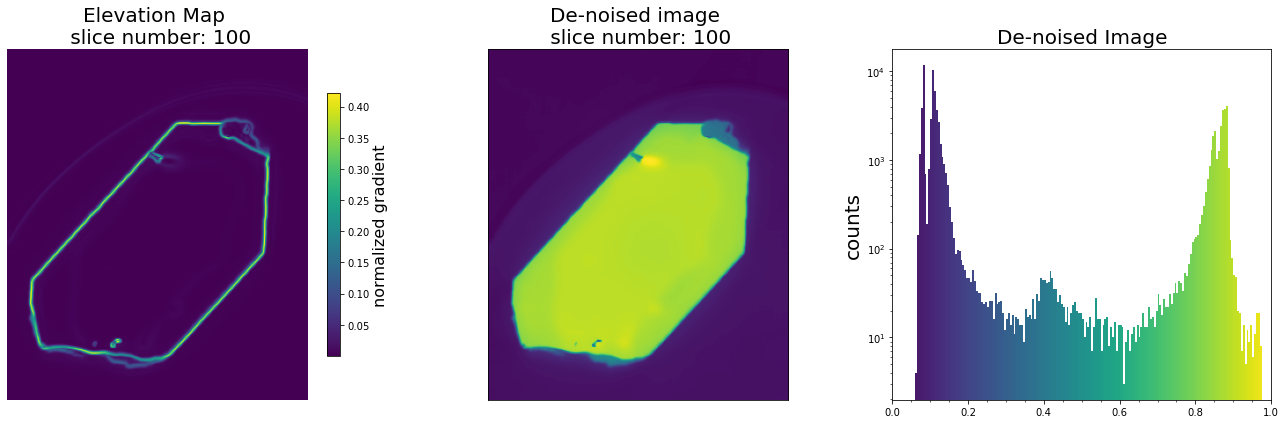

In [115]:
def create_elevation_map(smoothed_stack, method):
    """
    create_elevation_map utilizes the sobel filter from skimage to create an
    elevation map based on the gradient at each pixel. It iterates through the 
    entire stack of data to create an individual elevation map for each image

    Parameters
    ----------
    smoothed_stack : ndarray
        3D denoised data array
    
    method : string
        'sobel', 'roberts', 'scharr', 'prewitt'. This determines the type of 
        edge operator to use in creating the elevation map. See example here:
        https://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html

    Returns
    -------
    elevation_map : ndarray
        collection of elevation maps in same shape as input (3D ndarray)

    """
    elevation_map = np.zeros(smoothed_stack.shape)
    if method == "sobel":

        for i in tqdm(range(elevation_map.shape[0]), total = elevation_map.shape[0],unit = 'images'):
            elevation_map[i, :, :] = sobel(smoothed_stack[i, :, :])

    elif method == "roberts":
        for i in qdm(range(elevation_map.shape[0]), total = elevation_map.shape[0],unit = 'images'):
            elevation_map[i, :, :] = roberts(smoothed_stack[i, :, :])

    elif method == "scharr":
        for i in qdm(range(elevation_map.shape[0]), total = elevation_map.shape[0],unit = 'images'):
            elevation_map[i, :, :] = scharr(smoothed_stack[i, :, :])

    elif method == "prewitt":
        for i in qdm(range(elevation_map.shape[0]), total = elevation_map.shape[0],unit = 'images'):
            elevation_map[i, :, :] = prewitt(smoothed_stack[i, :, :])

    return elevation_map


elevation_algorithm = "sobel"
elevation_map = create_elevation_map(stack_nlm, method=elevation_algorithm)



slice_number = 100

fig, ax = plt.subplots(1,3,figsize=(18, 6))

m = ax[0].imshow(elevation_map[slice_number], cmap=cmap)
ax[0].set_title("Elevation Map \n slice number: {}".format(slice_number), fontsize=20)

cbar = fig.colorbar(m, ax=ax[0], shrink=0.75,)
cbar.set_label(label="normalized gradient", fontsize=16)
ax[0].axis("off")


# non local means image
ax[1].imshow(stack_nlm[slice_number], cmap=cmap)
ax[1].axes.yaxis.set_ticklabels([])
ax[1].axes.yaxis.set_ticks([])
ax[1].axes.xaxis.set_ticklabels([])
ax[1].axes.xaxis.set_ticks([])
ax[1].set_title('De-noised image \n slice number: {}'.format(slice_number),fontsize = 20)

# Histogram for rescaled image
counts, bins, patches = ax[2].hist(stack_nlm[slice_number].flatten(), bins=bins,)
ax[2].minorticks_on()
ax[2].set_xlim(0, 1)
ax[2].set_ylabel("counts", fontsize=20)
ax[2].set_title("De-noised Image", fontsize=20,)

# get the value for center of bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers, patches):
    plt.setp(p, "facecolor", colormap(c))
fig.tight_layout()
ax[2].set_yscale('log')



## Pick your markers for the segmentation

Although we apply the watershed algorithm to the elevation map created above, we first need to define our markers! Think of the algorithm starting at these markers and moving out (up) from there, classifying the image not just by pixel value, but it's topographical location relative to the pixels around it. Because this adds in a spatial component to the image segmentation, it often times produces more accurate results than simple thresholding. Based on the histogram above you will determine the number of segments for your image (i.e. background, sample holder, phase 1, phase 2, etc.). To set watershed markers, in brief, we create a new array that is the same shape as our stack, but fill it with 0s. We are then going to replace those 0s with 'marker' values for a certain pixel range.

In [130]:
#clasify the number of phases here and their normalized
#pixel limits. Note that for intermediate value phases
#you must specify a lower and upper limit
phase1_limit = [0.5]
phase2_limit = [0.6, 0.85]
phase3_limit = [0.87, 0.9]
phase4_limit = [0.9]

phase_limits = [phase1_limit, phase2_limit, phase3_limit, phase4_limit]
# empty marker array


def add_markers(stack_nlm, phase_limits):
    """
    Parameters:
    ----------
    
    stack_nlm | ndarray
    denoised data array. This is used to create the right size ndarray
    for the marker array
    
    phase_limits | list
    list of values to be used as delimiters for the phase boundaries.
    For phases that are neither the most or least attenuating values
    will be a list:
    
    phase_limits = [[0.5],
                    [0.6, 0.7],
                    [0.84]]
                    
    This will set markers for three phases where pixel locations with values
    less than 0.5 will be used as a marker for phase 1, locations with values 
    between 0.6 and 0.7 will be used as a marker for phase 2, locations with
    values greater than 0.84 will be used as a marker for phase 3. 
    
    Returns:
    --------
    
    markers | ndarray
    
    marker array the same shape as the input array. All unspecified marker
    locations are 0
    
    """
    markers = np.zeros(stack_nlm.shape)

    for j in range(len(phase_limits)):
        print("filling markers for phase: {}".format(j + 1))

        if len(phase_limits[j]) == 1:

            if j == len(phase_limits) - 1:
                print("pixel boundary: x > {}".format(phase_limits[j]))
                for i in tqdm(range(markers.shape[0]),total = markers.shape[0],unit = 'images'):
                    markers[i, :, :][stack_nlm[i] > phase_limits[j]] = j + 1
            else:
                print("pixel boundary: x < {}".format(phase_limits[j]))
                for i in tqdm(range(markers.shape[0]),total = markers.shape[0],unit = 'images'):
                    markers[i, :, :][stack_nlm[i] < phase_limits[j]] = j + 1

        elif len(phase_limits[j]) == 2:
            print(
                "pixel boundary: {} > x > {}".format(
                    phase_limits[j][0], phase_limits[j][1]
                )
            )
            for i in tqdm(range(markers.shape[0]),total = markers.shape[0],unit = 'images'):
                markers[i, :, :][
                    np.logical_and(
                        stack_nlm[i] > phase_limits[j][0],
                        stack_nlm[i] < phase_limits[j][1],
                    )
                ] = (j + 1)
    return markers


markers = add_markers(stack_nlm, phase_limits)

filling markers for phase: 1
pixel boundary: x < [0.5]


100%|██████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 5424.74images/s]


filling markers for phase: 2
pixel boundary: 0.6 > x > 0.85


100%|██████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 8791.12images/s]


filling markers for phase: 3
pixel boundary: 0.87 > x > 0.9


100%|█████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 11075.76images/s]


filling markers for phase: 4
pixel boundary: x > [0.9]


100%|█████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 21357.96images/s]


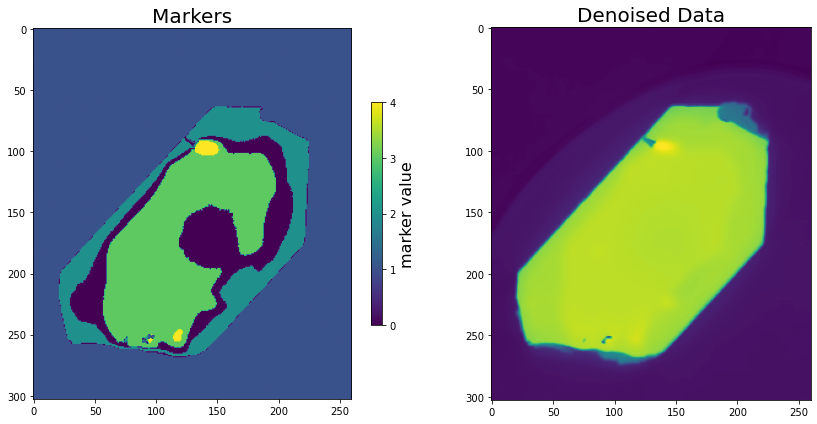

In [131]:
slice_number = 100
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
m = ax[0].imshow(markers[slice_number], cmap=cmap)
ax[0].set_title("Markers", fontsize=20)
bounds = np.linspace(0, 5, 6)

cbar = fig.colorbar(m, ax=ax[0], ticks=bounds, shrink=0.6,)
cbar.set_label(label="marker value", fontsize=16)
ax[1].imshow(stack_nlm[slice_number], cmap=cmap)
ax[1].set_title("Denoised Data", fontsize=20)

fig.tight_layout()

## Run the watershed segmentation

In [132]:
def run_watershed_segmentation(elevation_array, markers):
    """
    run_watershed_segmentation utilizes the watershed function from the segmentation
    module (https://scikit-image.org/docs/dev/api/skimage.segmentation.html) and 
    times the results
    
    run_watershed_segmentation(smoothed_stack,markers):

    Parameters
    ----------
    elevation_array : ndarray
        data to apply the watershed algorithm to. This is our elevation map
        3D matrix
    markers : ndarray
        marker array in the same shape as the "elevation_array" argument

    Returns
    -------
    ws_results : ndarray
        array in the same shape as the "elevation_array" array
        with values from "markers" as decided by the watershed
        algorithm

    """

    # containers
    segmentation = np.zeros(elevation_array.shape)
    for i in tqdm(range(elevation_array.shape[0]),total = elevation_array.shape[0], unit = 'images'):

        # fill segmentation array with watershed results for each slice
        segmentation[i, :, :] = watershed(elevation_array[i, :, :], markers[i, :, :])

    return segmentation


ws_results = run_watershed_segmentation(elevation_map, markers)
ws_results[ws_results == 1] = np.nan

100%|████████████████████████████████████████████████████████████████████████████| 299/299 [00:06<00:00, 43.59images/s]


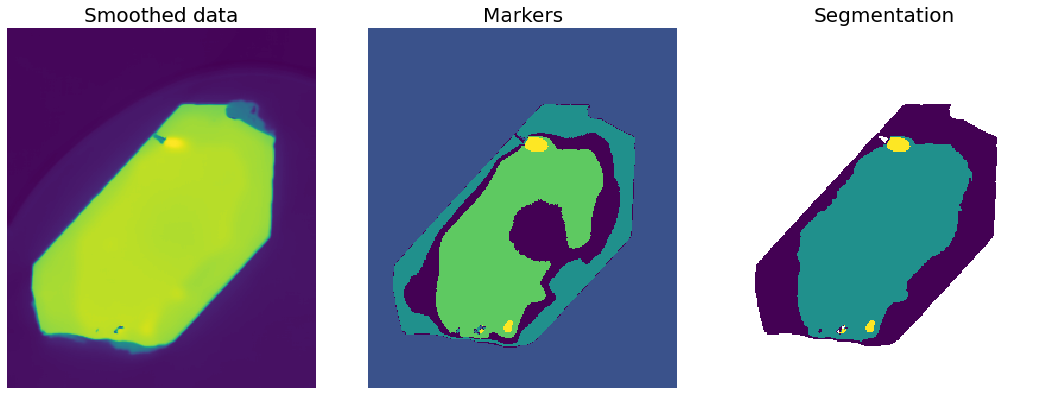

In [133]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(stack_nlm[slice_number], cmap=cmap, interpolation="nearest")
ax[0].axis("off")
ax[0].set_title("Smoothed data", fontsize=20)
ax[1].imshow(markers[slice_number], cmap=cmap, interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("Markers", fontsize=20)
ax[2].imshow(ws_results[slice_number], cmap=cmap, interpolation="nearest")
ax[2].axis("off")
ax[2].set_title("Segmentation", fontsize=20)

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

## Save results and make a report of all requisite metadata
Here we'll save the data as a stack of .tif files that represent the segmented images. We also save the metadata (e.g., all the input decisions made in the pipeline) to be reproducible.


In [134]:
# save your work as a numpy array so it is easier to 
# load up and work with in the future
np.save('{}/{}_seg_results.npy'.format(filepath,name),
        ws_results
       )

In [135]:
def save_seg_results(outpath, name, ws_results, cmap):
    """
    save_seg_results takes each segmented 2D image (array) and saves them as 
    individual images to a desired folder. 
    
    save_seg_results(outpath,name,ws_results):
    
    will save the images in the following format:
        "outpath/name_seg_results_z.tif" where "name" and "outpath" are strings
        input to the function and "z" is a 3 digit slice number 
        (i.e., 000, 001, 002)

    Parameters
    ----------
    outpath : string
        filepath to the folder where the images are to be saved
    name : string
        name for the dataset you are working with. Try to keep this consistent
        throughout the entire project.
    ws_results : ndarray
        results from the watershed segmentation

    Returns
    -------
    None.

    """

    for i in tqdm(range(ws_results.shape[0]),total = ws_results.shape[0], unit = 'image'):

        fig, axes = plt.subplots(nrows=1, ncols=1)
        ax0 = axes
        ax0.imshow(ws_results[i], cmap=cmap)  # choose your segmentation algorithm here
        ax0.axis("off")  # no axes so its just the image

        fig.set_size_inches(5, 5)
        fig.subplots_adjust(
            left=None, bottom=None, right=None, top=None, wspace=None, hspace=None
        )
        plt.savefig(
            "{}/{}_seg_results{}.tif".format(outpath, name, i), bbox_inches="tight"
        )
        plt.close()
    print("Your images have been saved to the following directory:\n{}".format(outpath))


# outpath = "/Volumes/JEL/Jorgenson_CT_work/0009_20CJ04_x7_A/"

save_seg_results(filepath, name, ws_results, cmap)

100%|█████████████████████████████████████████████████████████████████████████████| 299/299 [00:13<00:00, 21.89image/s]

Your images have been saved to the following directory:
D:\Jorgenson_CT_work\0103_19CJ13_x100\32bit


In [136]:
def save_metadata(outpath, filename):

    """
    Parameters:
    -----------
    
    outpath | string
    the directory to save the metadata to
    
    filename| the name of the file being saved
    
    
    
    Returns:
    --------
    
    None
    
    *will save a csv with metadata in the form of a table to the 
    specified directory. Ex:
    
        Parameter|value
        ----------------------
        name|0009_20CJ04_x7_A
        ------------------------------------
        original_stack_shape|(544, 860, 872)
        ------------------------------------
        processed_stack_shape|(272, 430, 436)
        ------------------------------------
        rescaled_percentile_values|[0.05, 99.97]
        ------------------------------------
        denoise_patch_size|10
        ------------------------------------
        denoise_patch_distance|10
        ------------------------------------
        elevation_map_algorithm|sobel
        ------------------------------------
        phase 1 normalized pixel boundary|[0.5]
        ------------------------------------
        phase 2 normalized pixel boundary|[0.6, 0.67]
        ------------------------------------
        phase 3 normalized pixel boundary|[0.7, 0.83]
        ------------------------------------
        phase 4 normalized pixel boundary|[0.84]

    """

    segmentation_metadata = {
        "name": name,
        "original_stack_shape": [original_stack_shape],
        "processed_stack_shape": [stack.shape],
        "rescaled_percentile_values": [[lower_lim, upper_lim]],
        "denoise_patch_size": patch_size,
        "denoise_patch_distance": patch_distance,
        "elevation_map_algorithm": elevation_algorithm,
    }
    for i, limit in enumerate(phase_limits):
        segmentation_metadata.update(
            {"phase {} normalized pixel boundary".format(i + 1): [limit]}
        )

    outfile = "{}_segmentation_metadata.csv".format(filename)

    df = pd.DataFrame(
        dict([(k, pd.Series(v)) for k, v in segmentation_metadata.items()])
    ).T.reset_index()
    df.columns = ["Parameter", "value"]
    df.to_csv(outpath + outfile, index=False)
    print(
        "Your metadata has been saved as:\n{}\n\nin the following directory: \n{}".format(
            outfile, outpath
        )
    )


save_metadata(filepath, name)

Your metadata has been saved as:
0103_19CJ13_x100_segmentation_metadata.csv

in the following directory: 
D:\Jorgenson_CT_work\0103_19CJ13_x100\32bit
